# XGboost算法

### 补充知识
#### 1. 树的复杂度
##### ①叶节点个数  ②树的深度  ③叶节点值
##### 叶节点值可以评估树的复杂度：因为模型是对残差进行训练，如果我们设置的叶节点值很小，那么就需要很多棵树来训练，反之就只需要很少树
##### 如真实值是1000，如果我们设置叶节点值最大只能是100，那么至少需要10棵树，而如果最大值是1000，可能1棵树就行
#### 2. 泰勒级数
##### 概念：在数学中，泰勒级数（英语：Taylor series）用无限项连加式——级数来表示一个函数，这些相加的项由函数在某一点的导数求得
##### 定义：如果在点$f(x)$在点$x=x0$具有任意阶导数，则幂级数
##### $$ \sum_{n=0}^∞\frac{f^{(n)}(x_0)}{n!}(x-x_0)^n =f(x_0)+f'(x_0)(x-x_0)+\frac{f''(x_0)}{2!}(x-x_0)^2+...+\frac{f^{(n)}(x_0)}{n!}(x-x_0)^n+...$$

### XGboost的优势
##### 算法可并行、训练效率高
##### 实际效果好
##### 超参数多、可灵活调整

###### 视频来源：贪心科技公开课
###### 视频链接：https://www.bilibili.com/video/BV1Sf4y187Cd?spm_id_from=333.337.search-card.all.click&vd_source=0ff0741b73604c1a438ec142a82cb36a

## 一、Bagging 与 Boosting的区别
### Bagging的基学习器是过拟合overfitting的
### Boosting的基学习器是欠拟合underfitting的
##### （每个基学习器都是这样子吗？）

## 二、提升树：基于残差的训练
#### 对原始数据 ，训练$model_1$，获得预测值$\hat y_1$，计算残差$residual_1$
#### 对$residual_1$，训练$model_2$，获得预测值$\hat y_2$，计算残差$residual_2$
#### 对$residual_2$，训练$model_3$，获得预测值$\hat y_3$，计算残差$residual_3$
#### ......
#### 组合$model_1 + model_2 + model_3$，获得最终预测结果$\hat y = \hat y_1 + \hat y_2 + \hat y_3 + ...$，计算残差$y - \hat y$
###### PS：而随机森林是对原始数据进行Bagging，训练n个model，然后对每个model的结果进行投票，获得最终结果

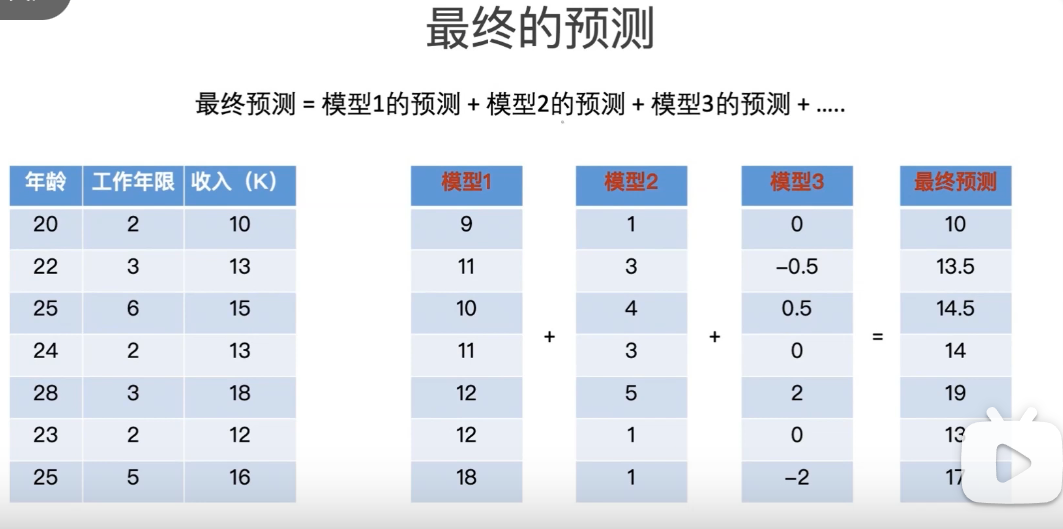

## 三、XGboost算法

### 1. 使用多棵树来预测
#### 假设已经训练了k棵树，则对于第i个样本的最终预测值为
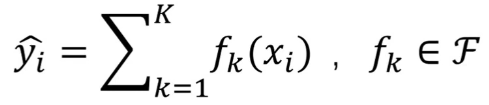
#### 其中$f_k(x_i)$表示第k棵树对第i个样本的预测值

### 2. 目标函数的构建
### 2.1 目标函数
#### l为损失函数。至于具体取什么函数，可以根据具体情况代入
#### Ω为惩罚项，防止过拟合，常用为L1/L2正则化
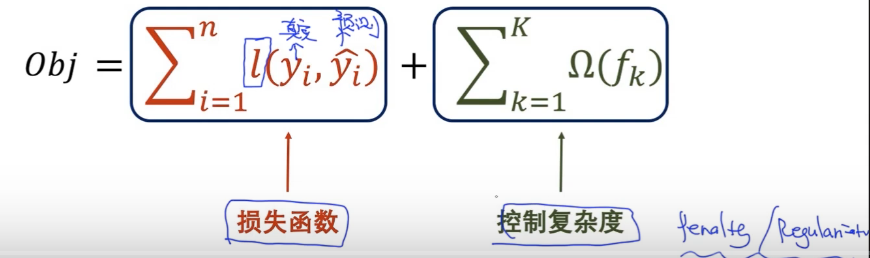

### 2.2 构建过程：Additive Training（叠加式的训练） 
#### 假设模型由k棵树构成，前边k-1棵树已知，现在在训练第k棵树
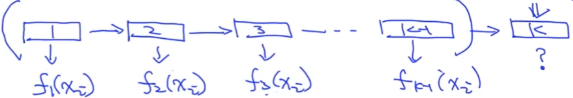
#### 其中$f_k(x_i)$ 代表第$k$棵树对第$i$ 个样本的预测结果，下述的$\hat y_i^{(k)}$是前$k$棵树的预测结果
##### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### 当我们给定样本$x_i$，则有
##### 第0棵树：$\hat y_i^{(0)} = 0$
##### 第1棵树：$\hat y_i^{(1)} = f_1(x_i) = \hat y_i^{(0)} + f_1(x_i)$
##### 第2棵树：$\hat y_i^{(2)} = f_1(x_i) + f_2(x_i) = \hat y_i^{(1)} + f_2(x_i)$
##### ......
##### 第k棵树：$\hat y_i^{(k)} = f_1(x_i) + f_2(x_i) + ... + f_k(x_i) = \sum_{j=0}^{k-1}{f_j^{(x_i)}} + f_k(x_i)$
##### 即由前$k-1$棵树的预测值加上第$k$棵树的预测值
##### 注意这里第$k$棵树训练的是第$k-1$棵树的残差，如第2棵树的公式移项可得$\hat y_i^{(2)}-\hat y_i^{(1)}=f_2(x_i)$
##### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
####  因此目标函数为：$$obj = \sum_{i=1}^{n}l(y_i,\hat y_i^{(k)}) + \sum_{j=1}^{k}\Omega (f_j)$$
#### 其中第一项为真实值与预测值的差，第二项为树的复杂度（惩罚项）
#### 目标是$$ minimize \ \  obj = \sum_{i=1}^{n}l(y_i,\hat y_i^{(k-1)}+f_k(x_i)) + \sum_{j=1}^{k-1}\Omega (f_j)+\Omega (f_k) $$
#### 其中$\hat y_i^{(k-1)}$是前$k-1$棵树的预测结果，是已知的constant，暂不约掉
#### 而因为前$k-1$棵树已经是确定的了，所以其惩罚项$\sum_{j=1}^{k-1}\Omega (f_j)$也是已知的，可以约掉
#### 最终的目标是$$ minimize \  obj = \sum_{i=1}^{n}l(y_i,\hat y_i^{(k-1)}+f_k(x_i)) + \Omega (f_k) $$

### 2.3 使用泰勒级数近似目标函数
#### $obj = \sum_{i=0}^{n}l(y_i,\hat y_i^{(k-1)}+f_k(x_i)) + \Omega (f_k) $
#### 泰勒展开式： $ f(x+\delta x)≈f(x)+f'(x)\Delta x + \frac{1}{2}f''\Delta x^2 $
#### 令（近似过程）：$f(x)=l(y_i,\hat y_i^{(k-1)}),f(x+\Delta x)=l(y_i,\hat y_i^{(k-1)}+f_k(x_i))$
#### 则有$$ obj = \sum_{i=1}^{n}l(y_i,\hat y_i^{(k-1)}+f_k(x_i)) + \Omega (f_k) $$
#### $$ \sum_{i=1}^{n}[l(y_i-\hat y_i^{(k-1)})+\partial _{\hat y_i^{(k-1)}}\ \ \ l(y_i-\hat y_i^{(k-1)})\cdot f_k(x_i)+\frac{1}{2}{\partial ^2}_{\hat y_i\ \ ^{(k-1)}}\cdot f^{2}_k(x_i)]+ \Omega (f_k)$$
#### 其中$y_i$与$y_i^{(k-1)}$是已知的，因此$l(y_i-\hat y_i^{(k-1)})$可以直接约掉
#### 再令$g_i = \partial _{\hat y_i^{(k-1)}}\ \ \ l(y_i-\hat y_i^{(k-1)}),h_i={\partial ^2}_{\hat y_i\ \ ^{(k-1)}}$
#### 可得：
#### $$ obj = \sum_{i=1}^{n}[g_if_k(x_i)+\frac{1}{2}h_if^{2}_k(x_i)]+ \Omega (f_k) $$
##### （注意：当训练第k棵树的时候，{$g_i,h_i$}是已知的，$g_i$是一阶导，$h_i$是二阶导，其包含了前$k-1$棵树训练的残差信息，具体求导过程，取决于所应用的损失函数，待研究）
#### 新的目标函数
#### $$ minimize \ \ \ obj = \sum_{i=1}^{n}[g_if_k(x_i)+\frac{1}{2}h_if^{2}_k(x_i)]+ \Omega (f_k) $$

### 2.4 重新定义一棵树
#### ①假设一棵树从左到右的叶节点值分别为$w_1,w_2,w_3,...，$则这棵树可以表示为$w=(w_1,w_2,w_3,...)$
#### ②令$q(x)$表示样本$x$的位置，则第$k$棵树对样本$x_i$的预测值可以表示为$f_k(x_i)=w_{q(x_i)}$
#### ③每个叶节点上的样本集合可以表示为：$I_j=\{i|q(x_i)=j\}$
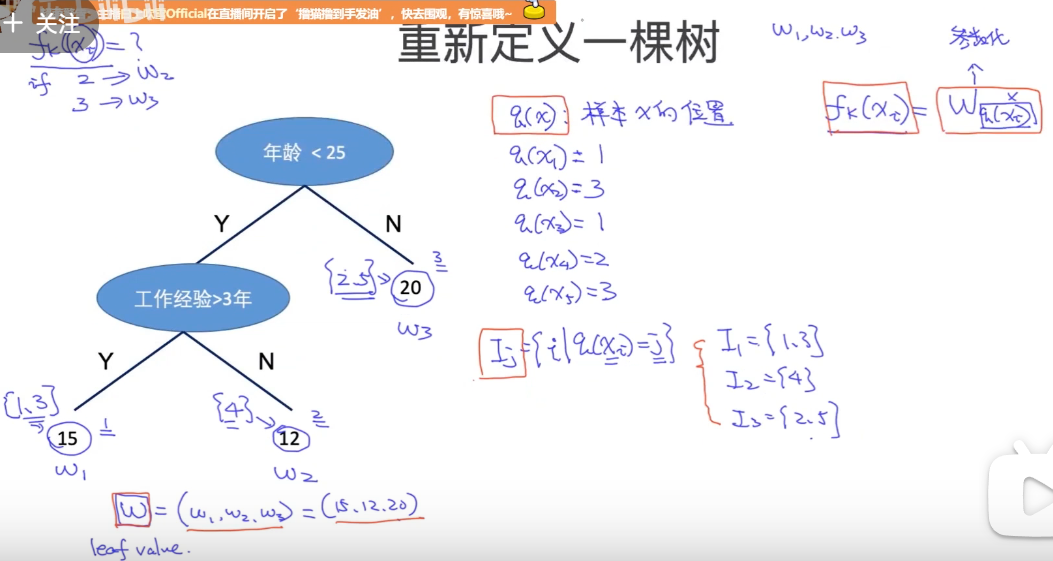
#### ④树的复杂度，在以上定义下，复杂度可以表示为：树的复杂度 = +叶节点个数+叶节点值，即
#### $$ \Omega (f_k)=\gamma T+\frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$$
##### （备注：T是指叶节点个数，两个参数$\gamma,\lambda$是论文里的）

### 2.5 再次构造新的目标函数
#### 现在的目标函数为：$obj = \sum_{i=0}^{n}[g_if_k(x_i)+\frac{1}{2}h_if^{2}_k(x_i)]+ \Omega (f_k)$
#### 同时我们在树的形状已知的前提（假设已知），我们也构造了新的损失函数：$ \Omega (f_k)=\gamma T+\frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$
#### 则有：$$obj = \sum_{i=1}^{n}[g_if_k(x_i)+\frac{1}{2}h_if^{2}_k(x_i)]+ \gamma T+\frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$$
#### 上述公式是遍历每一个样本进行计算，然后求和，但在我们已知树形状的假设下，2.4中 {$w,q(x_i),I_j$} 均已知，我们可以遍历每一个叶节点
#### 即有：$$ obj=\sum_{i=1}^{n}[g_i\cdot w_{q(x_i)}+\frac{1}{2}h_i\cdot w_{q(x_i)}^{2}] +\gamma T+\frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$$
#### $$= \sum_{J=1}^{T}[(\sum_{i\in I_j}g_i)\cdot w_j+\frac{1}{2}(\sum_{i\in I_j}h_i+\lambda)\cdot w_j^2]+\gamma T$$
#### 因为{$g_i,h_i,T,\lambda,\gamma$}均是已知的，因此转换为一元二次方程求最优解：$$w_j^*=-\frac{b}{2a}=-\frac{G_j}{H_j+\lambda}$$
#### $obj$的最优解为：$$ obj^{*}=-\frac{1}{2}\sum_{j=1}^{T}\frac {G_j^2}{H_j+\lambda}+\gamma T $$
##### （备注：从遍历样本转换为遍历叶节点的思路如下图所示：）
###### 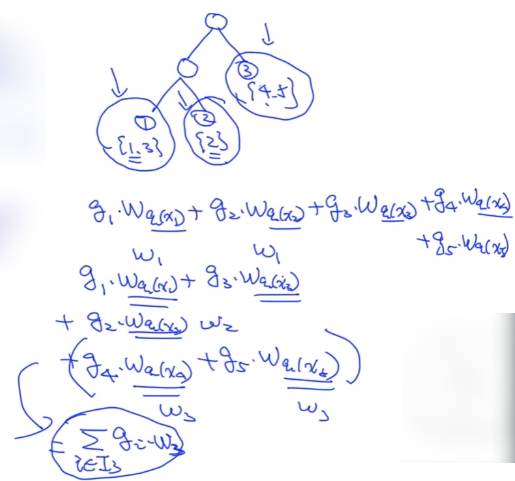

### 2.6 第k棵树的构造
#### 2.6.1 遍历
#### 先前我们假设第k棵树的形状是已知的，但实际是未知的，解决方法是遍历这棵树所有可能的形状
#### 可得：$obj_k^{*(1)},obj_k^{*(2)},obj_k^{*(3)},...obj_k^{*(x)}$
#### 求解 $min(obj_k^{*(i)})$，由于是对一元二次方程进行求解，这个求解过程是很快的，且是可并行的，
#### 但是这个问题是个NP hard问题，随着特征的增加，计算量是指数级增加的
#### 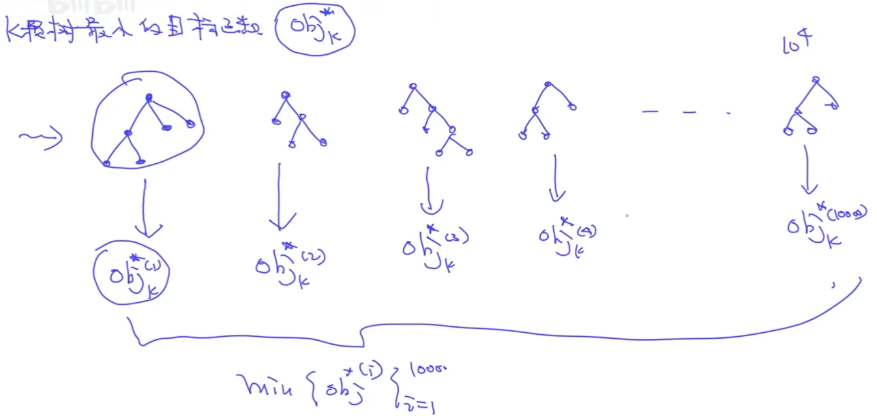

#### 2.6.2 贪心算法（局部最优解，每一步上都求最优，而不是全局最优）
#### 决策树寻找分裂节点的方法是计算分裂前后的信息增益 information Gain，即原(不确定性) - 新(不确定性)
#### 将这种应用到寻找 $min(obj_k^{*(i)})$上，节点分裂之前可以计算一个$old(obj)$，
#### 在节点分裂之后即生成一棵形状已知的树，那么就可以计算一个$new(obj)$，计算$old(obj)-old(obj)$
#### 即树的构造不再根据信息熵、信息增益等，而是根据损失函数$obj$
##### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##### 具体计算过程如下:
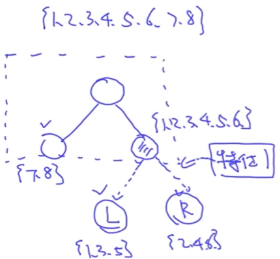
##### 假设原始只有两个叶节点，$L1(7,8),R1(1,2,3,4,5,6),\{1\}表示是第一层$，现在尝试根据$feature1$对$R1_old$进行分裂，
##### 假设分裂后后结果为：$L1(7,8),L2(1,3,5),R2(2,4,6)$
##### 损失函数为：$obj=-\frac{1}{2}\sum_{j=1}^{T}\frac {G_j^2}{H_j+\lambda}+\gamma T $
##### 则原始的损失函数为$obj_{old}^*=-\frac{1}{2}[\frac{{(g_7+g_8)}^2}{h_7+h_8+\lambda}+\frac{{(g_1+...+g_6)}^2}{h_1+...+h_6+\lambda}] +2\gamma $
##### 分裂后的损失函数为$obj_{new}^*=-\frac{1}{2}[\frac{{(g_7+g_8)}^2}{h_7+h_8+\lambda}+\frac{{(g_1+g_3+g_5)}^2}{h_1+h_3+h_5+\lambda}+\frac{{(g_2+g_4+g_6)}^2}{h_2+h_4+h_6+\lambda}] +3\gamma $
##### $$obj_{old}^*-obj_{new}^*=\frac{1}{2}[\frac{{(g_1+g_3+g_5)}^2}{h_1+h_3+h_5+\lambda}+\frac{{(g_2+g_4+g_6)}^2}{h_2+h_4+h_6+\lambda}-\frac{{(g_1+...+g_6)}^2}{h_1+...+h_6+\lambda}]-\gamma$$
##### 取最大的$obj_{old}^*-obj_{new}^*$进行分裂
##### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------